## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Give It More Time Or Not](#check)
- [Part V - Final Conclusion](#conclusion)

<a id='intro'></a>
### Introduction


For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [112]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
import datetime as dt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Reading the dataset and take a look at the top few rows here:

In [113]:
df = pd.read_csv('ab_data.csv') #reading the data set
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. finding the number of rows in the dataset.

In [114]:
df.shape[0], df.shape

(294478, (294478, 5))

c. The number of unique users in the dataset.

In [115]:
len(df.user_id.unique())

290584

d. The proportion of users converted.

In [116]:
len(df.query('converted==1').user_id.unique()) / len(df.user_id.unique())

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [117]:
df.query('group=="treatment" and landing_page !="new_page"').user_id.count() + df.query('group=="control" and landing_page !="old_page"').user_id.count() 

3893

f. Do any of the rows have missing values?

In [118]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page so we will remove those rows. 


In [119]:
df2 = df.query('(group=="treatment" and landing_page =="new_page") or (group=="control" and landing_page=="old_page")')

In [120]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [121]:
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [122]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [123]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [124]:
df2 = df2.drop(index=2893)

In [125]:
df2[df2.user_id.duplicated()]


,user_id,timestamp,group,landing_page,converted


a. What is the probability of an individual converting regardless of the page they receive?

In [126]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [127]:
control_group_proportion = df2[df2['group'] == "control"]['converted'].mean()
control_group_proportion

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [128]:
treat_group_proportion = df2[df2['group'] == "treatment"]['converted'].mean()
treat_group_proportion

0.11880806551510564

In [129]:
treat_group_proportion - control_group_proportion

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [130]:
df2.query('landing_page=="new_page"').user_id.count() / df2.user_id.count()

0.50006194422266881

**it seems that there is no sufficient evidence to conclude that the new treatment page leads to more conversions since the probability is 0.11**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The null hypthoesis: the old page is better than or equal to the new page (p_new - p_old <= 0)<br>
The alternative hypthoesis: the new page is better than the old page (p_new - p_old > 0)
.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [131]:
# here we will make the proportion of two pages the same as the old page which our null hypthoesis
#p_new = df2.query('landing_page == "old_page"').converted.mean()
# conversion of new page under the null
p_new = df2[df['landing_page'] == 'old_page'].converted.mean()
p_new

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


0.1203863045004612

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [132]:
# here we will make the proportion of two pages the same as the old page which our null hypthoesis
#p_old = df2.query('landing_page == "old_page"').converted.mean()
# conversion of old page under the null
p_old = df2[df['landing_page'] == 'old_page'].converted.mean()
p_old

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


0.1203863045004612

c. What is $n_{new}$, the number of individuals in the treatment group?

In [133]:
n_new = df2.query('landing_page == "new_page"').user_id.count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [134]:
n_old = df2.query('landing_page == "old_page"').user_id.count()
n_old

145274

In [135]:
#conversion difference under the null
p_new - p_old


0.0

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [136]:
#new_page_converted = np.random.choice(df2.query('landing_page == "new_page"')['converted'], n_new, replace=True)
new_page_converted = np.random.choice([0,1], size = n_new, p = [(1 - p_new), p_new])

sum(new_page_converted), len(new_page_converted)

(17504, 145310)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [137]:
old_page_converted = np.random.choice([0,1], size = n_old, p = [(1 - p_old), p_old])

sum(old_page_converted), len(old_page_converted)
#old_page_converted = np.random.choice(df2.query('landing_page == "old_page"')['converted'], n_new, replace=True)

#sum(old_page_converted)

(17558, 145274)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [138]:
difference_between_samples = new_page_converted.mean() - old_page_converted.mean()
difference_between_samples

-0.00040156221654261137

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [139]:
p_diff = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diff = new_converted_simulation - old_converted_simulation


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

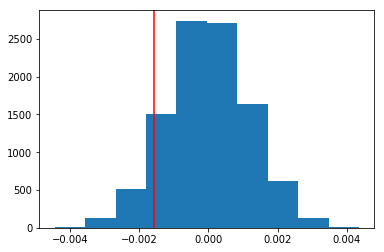

In [140]:
plt.axvline(treat_group_proportion - control_group_proportion, color='r')
plt.hist(p_diff);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [141]:
null_sumlation = np.random.normal(0, np.std(p_diff), 10000)

(array([    8.,    93.,   551.,  1699.,  3009.,  2766.,  1431.,   374.,
           60.,     9.]),
 array([ -4.63859830e-03,  -3.69116020e-03,  -2.74372210e-03,
         -1.79628399e-03,  -8.48845893e-04,   9.85922093e-05,
          1.04603031e-03,   1.99346841e-03,   2.94090651e-03,
          3.88834462e-03,   4.83578272e-03]),
 <a list of 10 Patch objects>)

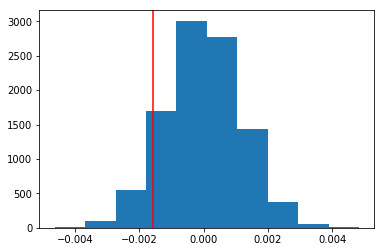

In [142]:
plt.axvline((treat_group_proportion - control_group_proportion), color='r')
plt.hist(null_sumlation)

In [143]:
(p_diff >= (treat_group_proportion - control_group_proportion)).mean()

0.90669999999999995

**P-value = 0.90 which means that we can not reject the null hypthoessis and the convert of the old page is greater**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [144]:
import statsmodels.api as sm

convert_old = np.random.choice(2, size = n_old, p = [1 - p_old, p_old])
convert_new = np.random.choice(2, size = n_new, p = [1 - p_new, p_new])
n_old = df2.query('landing_page == "old_page"').user_id.count()
n_new = df2.query('landing_page == "new_page"').user_id.count()

In [145]:
s_old = df2.query('group=="control" and converted==1')['converted'].count()
s_old

17489

In [146]:
s_new = df2.query('group=="treatment" and converted==1')['converted'].count()
s_new

17264

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [147]:
# resource: https://sonalake.com/latest/hypothesis-testing-of-proportion-based-samples/
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

sample_success_a, sample_size_a = (s_old, n_old)
sample_success_b, sample_size_b = (s_new, n_new)
successes = np.array([sample_success_a, sample_success_b])
samples = np.array([sample_size_a, sample_size_b])
stat, p_value = proportions_ztest(count=successes, nobs=samples, alternative="smaller")
# report
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))

z_stat: 1.311, p_value: 0.905


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Yes, because the p-value is equal = 0.90 which also means we fail to reject the null.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

In [148]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [149]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df['landing_page'])['new_page'] # converting categorical landing_page column to zeros and ones, ones for new page
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [150]:
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]) # fiting the model
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [151]:
df2[df2['ab_page'] == 1]['converted'].mean()

0.11880806551510564

In [152]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-30 06:52 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**
##### P value = 0.189 it different because it is two tails <br>
##### We Can consider one tail here by dividing p-value by 2  if we do this we are still faill to reject the null because it will be equal to <br> 1 - 0.188/ 2) = 0.90
<br><br>
**Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The null in regression model says that there is no difference betweeen two proportion: P_new - P_old = 0 <br>
The Alternative in regression model syas that there is a difference between two proportion: p_new - P_old != 0<br>
so this is a two tails test compared two one tail test in part II  which is one tail test, and we can compare each other by<br> diving the resualt of P_value in two tails test by 2**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Yes, because by using landing page as the only feature on our model makes the model dependent only on the proportion of `converted` which was not important enough to build a model after geting the proportion and p-value from previous part using A/B testing and when adding more factors this will make us individualize predictions**

In [153]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()
joined_df = df2.join(df_countries.set_index('user_id'), on='user_id') # joining two datasets with user_id as a key
joined_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [154]:
joined_df[['CA', 'UK', 'US']] = pd.get_dummies(joined_df['country']) # convert categorical varibles to zeros and ones
model = sm.Logit(joined_df['converted'], joined_df[['intercept' ,'CA', 'UK']])
result = model.fit() # finting the model
result.summary2() # showing the result

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-30 06:52 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

- As we see here from p-values of CA and UK there is no significant that the country has effect on conversion rate.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [155]:
joined_df[['CA', 'UK', 'US']] = pd.get_dummies(joined_df['country']) # convert categorical varibles to zeros and ones
joined_df['ab_CA'] = joined_df['ab_page'] * joined_df['CA']
joined_df['ab_UK'] = joined_df['ab_page'] * joined_df['UK']
model = sm.Logit(joined_df['converted'], joined_df[['intercept', 'ab_page' ,'CA', 'UK', 'ab_CA', 'ab_UK']]) # most valuable columns
result = model.fit() # finting the model
result.summary2() # showing the result

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-30 06:52 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_CA        -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
ab_UK         0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

- 1.. The base(intercept) represents: when the user came from US and landing page is the old page
- 2.. the ab_page coefficient represents: when the user came from US and landing page is the new page
- From 1 and 2 we can see that there is no statistical significant that the page type influence the conversion for people came for US the p-value = 0.1323
- 3.. The ab_CA and ab_UK represents: when the user came from CA and UK and the lading page is the new page 
- 4.. The CA coefficient represents: when the user came from CA and landing page is the old page
- 5.. The UK coefficient represents: when the user came from UK and landing page is the old page
- 6.. From p-values of ab_CA and ab_UK we can see that there is no statistical significant that there is a difference between the base(intercept) and ab_CA and ab_UK so we can compare CA's and UK's P-values to the intercept and we can double check by calculating the distance between intercept and ab_CA and ab_UK and compare it to the distance between CA and ab_CA or UK and ab_UK.
- From 3, 4, 5 and 6: we can compare CA and UK coefficients to the base(intercept) and see that there is no statistical significant that the page type influence the conversion rate for people came from CA and UK
### There is no statstical significant that the page type is influence the conversion rate for each country.

In [156]:
joined_df.query('CA == 1 and ab_page == 0')['converted'].mean()

0.11878299527646569

In [157]:
joined_df.query('US == 1 and ab_page == 1')['converted'].mean()

0.11846559963887227

In [158]:
probability_of_convert_people_from_CA = 1 / (1 + np.exp(-1 * (result.params[0] + result.params[4])))
print(probability_of_convert_people_from_CA)

0.115744344218


In [159]:
probability_of_convert_people_from_CA = 1 / (1 + np.exp(-1 * (result.params[0] + result.params[2])))
print(probability_of_convert_people_from_CA)

0.118782995276


- The Probability of convert if the people from CA and landing page is new page entered = 0.115
- The Probability of convert if the people from CA and landing page is old page entered = 0.118

In [160]:
probability_of_convert_people_from_UK = 1 / (1 + np.exp(-1 * (result.params[0] + result.params[5])))
print(probability_of_convert_people_from_UK)

0.124000487937


In [161]:
probability_of_convert_people_from_UK = 1 / (1 + np.exp(-1 * (result.params[0] + result.params[3])))
print(probability_of_convert_people_from_UK)

0.1200220022


- The Probability of convert if the people from UK entered and the landing page is new page = 0.124
- The Probability of convert if the people from UK entered and the landing page is old page = 0.120

In [162]:
probability_of_convert_people_from_US = 1 / (1 + np.exp(-1 * (result.params[0] + result.params[1])))
print(probability_of_convert_people_from_US)

0.118465599639


In [163]:
probability_of_convert_people_from_US = 1 / (1 + np.exp(-1 * (result.params[0])))
print(probability_of_convert_people_from_US)

0.120629989382


- The Probability of convert if the people from US entered and landing page is new page = 0.118
- The Probability of convert if the people from US entered and landing page is old page = 0.120


- It seams that if we use logistic regression on this dataframe the perdiction will always be zero -not converted- because the probability does not exceed 0.5 in all cases

In [164]:
# here I do a sample check to see if the sklearn give the same result as the statsmodel or not
# from sklearn.datasets import load_iris
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0, fit_intercept=True).fit(joined_df[['CA', 'UK']], joined_df['converted'])

In [165]:
# clf.coef_

In [166]:
#clf.intercept_

<a id='check'></a>
### Part IV - Give It More Time Or Not
#### Now I'm trying to see if it good to give the test more time or that is enough
- I will do this by trying to do Hypothesis testing for each day cumulative and not cumulative and see their p-values over time.

In [167]:
# this functions return p-value for every data frame it takes.
# def hypth2(df_hypth):
#     n_new_local = df_hypth[df_hypth['landing_page'] == "new_page"]['user_id'].count() # number of users in new page
#     n_old_local = df_hypth[df_hypth['landing_page'] == "old_page"]['user_id'].count() # number of users in old page
#     p_new_local = df_hypth[df_hypth['landing_page'] == "new_page"]['converted'].mean() # proportion of new page
#     p_old_local = df_hypth[df_hypth['landing_page'] == "old_page"]['converted'].mean() # proportion of old page
#     difference_between_samples = p_new_local - p_old_local # difference between proportions
#     #print('Statstic', difference_between_samples)
#     p_diff = []
#     # bootstraping 
#     for _ in range(10000): 
#         new_page_converted = np.random.choice(2, size = n_new_local, p = [1 - p_new_local, p_new_local])
#         old_page_converted = np.random.choice(2, size = n_old_local, p = [1 - p_old_local, p_old_local])
#         p_diff.append(new_page_converted.mean() - old_page_converted.mean())

#     null_distr = np.random.normal(0, np.std(p_diff), 10000) # simulating the null
#     p_value = (null_distr > difference_between_samples).mean() # calculating the p-value
#     return p_value

In [168]:
# new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
# old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
# p_diffs = new_converted_simulation - old_converted_simulation
# plt.hist(p_diffs)

In [169]:
# this functions return p-value for every data frame it takes.
def hypth(df_hypth):
    n_new_local = df_hypth[df_hypth['landing_page'] == "new_page"]['user_id'].count() # number of users in new page
    n_old_local = df_hypth[df_hypth['landing_page'] == "old_page"]['user_id'].count() # number of users in old page
    p_new_local = df_hypth[df_hypth['landing_page'] == "new_page"]['converted'].mean() # proportion of new page
    p_old_local = df_hypth[df_hypth['landing_page'] == "old_page"]['converted'].mean() # proportion of old page
    difference_between_samples = p_new_local - p_old_local # difference between proportions
    #print('Statstic', difference_between_samples)
    p_diff = []
    # bootstraping 
    new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
    old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
    p_diff = new_converted_simulation - old_converted_simulation
    null_distr = np.random.normal(0, np.std(p_diff), 10000) # simulating the null
    p_value = (null_distr > difference_between_samples).mean() # calculating the p-value
    return p_value

In [170]:
df2['Datetime_without_hours'] = pd.to_datetime(df2['timestamp'], format="%Y-%m-%d") # converting string to datetime type
df2['Datetime_without_hours'] = pd.to_datetime(df2['Datetime_without_hours'], format="%Y-%m-%d").dt.date # cuting hours, minutes and seconds
df2['Datetime_without_hours'].min(), df2['Datetime_without_hours'].max() # min and max dates

(datetime.date(2017, 1, 2), datetime.date(2017, 1, 24))

In [171]:
p_values_per_day_commulative ={} 
for i in range(3, 26):
    date = dt.datetime.strptime('2017-01-{}'.format(i), "%Y-%m-%d").date() # getting day after day
    df_day = df2[df2['Datetime_without_hours'] < date] 
    if df_day['user_id'].count() == 0: # to skip errors if there is a gap between days
        continue
    #print(df_day)
    dic_date_key = dt.datetime.strptime('2017-01-{}'.format(i - 1), "%Y-%m-%d").date()
    p_values_per_day_commulative[dic_date_key] = hypth(df_day) # saving the p-values returned

In [172]:
type(p_value)

numpy.float64

In [173]:
p_values_per_day_commulative

{datetime.date(2017, 1, 2): 1.0,
 datetime.date(2017, 1, 3): 0.93479999999999996,
 datetime.date(2017, 1, 4): 0.996,
 datetime.date(2017, 1, 5): 0.99990000000000001,
 datetime.date(2017, 1, 6): 0.91830000000000001,
 datetime.date(2017, 1, 7): 0.97050000000000003,
 datetime.date(2017, 1, 8): 0.90849999999999997,
 datetime.date(2017, 1, 9): 0.91259999999999997,
 datetime.date(2017, 1, 10): 0.43569999999999998,
 datetime.date(2017, 1, 11): 0.57340000000000002,
 datetime.date(2017, 1, 12): 0.5554,
 datetime.date(2017, 1, 13): 0.71179999999999999,
 datetime.date(2017, 1, 14): 0.83930000000000005,
 datetime.date(2017, 1, 15): 0.90629999999999999,
 datetime.date(2017, 1, 16): 0.91890000000000005,
 datetime.date(2017, 1, 17): 0.86099999999999999,
 datetime.date(2017, 1, 18): 0.85360000000000003,
 datetime.date(2017, 1, 19): 0.86709999999999998,
 datetime.date(2017, 1, 20): 0.81969999999999998,
 datetime.date(2017, 1, 21): 0.90649999999999997,
 datetime.date(2017, 1, 22): 0.9022,
 datetime.date

In [174]:
# for getting the dates ordered
od = collections.OrderedDict(sorted(p_values_per_day_commulative.items()))
od

OrderedDict([(datetime.date(2017, 1, 2), 1.0),
             (datetime.date(2017, 1, 3), 0.93479999999999996),
             (datetime.date(2017, 1, 4), 0.996),
             (datetime.date(2017, 1, 5), 0.99990000000000001),
             (datetime.date(2017, 1, 6), 0.91830000000000001),
             (datetime.date(2017, 1, 7), 0.97050000000000003),
             (datetime.date(2017, 1, 8), 0.90849999999999997),
             (datetime.date(2017, 1, 9), 0.91259999999999997),
             (datetime.date(2017, 1, 10), 0.43569999999999998),
             (datetime.date(2017, 1, 11), 0.57340000000000002),
             (datetime.date(2017, 1, 12), 0.5554),
             (datetime.date(2017, 1, 13), 0.71179999999999999),
             (datetime.date(2017, 1, 14), 0.83930000000000005),
             (datetime.date(2017, 1, 15), 0.90629999999999999),
             (datetime.date(2017, 1, 16), 0.91890000000000005),
             (datetime.date(2017, 1, 17), 0.86099999999999999),
             (datetime.date

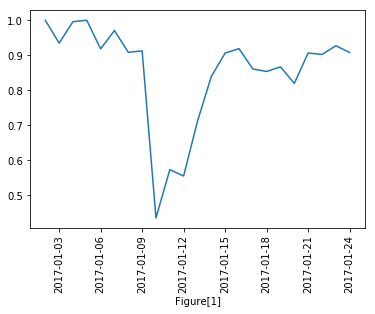

In [175]:
# here we drawing the p-values to see the trend
#fig = plt.figure(figsize=(20,20));
plt.plot(od.keys(), od.values());
plt.xlabel("Figure[1]")
plt.xticks(rotation=90);

In [176]:
# here we do the same thing as a pervious one in cmulative p-values but here we get the p-value for every single day
import datetime as dt
p_values_per_day ={} 
for i in range(3, 26):
    min_date = dt.datetime.strptime('2017-01-{}'.format(i - 1), "%Y-%m-%d").date()
    max_date = dt.datetime.strptime('2017-01-{}'.format(i), "%Y-%m-%d").date()
    df_day = df2.query('Datetime_without_hours >= @min_date and Datetime_without_hours < @max_date')
    if df_day['user_id'].count() == 0:
        continue
    #print(df_day)
    dic_date_key = dt.datetime.strptime('2017-01-{}'.format(i - 1), "%Y-%m-%d").date()
    p_values_per_day[dic_date_key] = hypth(df_day) # saving p-values

In [177]:
# getting the dates ordered to make visualization easy
od = collections.OrderedDict(sorted(p_values_per_day.items()))
od

OrderedDict([(datetime.date(2017, 1, 2), 1.0),
             (datetime.date(2017, 1, 3), 0.51039999999999996),
             (datetime.date(2017, 1, 4), 1.0),
             (datetime.date(2017, 1, 5), 1.0),
             (datetime.date(2017, 1, 6), 0.0),
             (datetime.date(2017, 1, 7), 1.0),
             (datetime.date(2017, 1, 8), 0.065199999999999994),
             (datetime.date(2017, 1, 9), 0.9083),
             (datetime.date(2017, 1, 10), 0.0),
             (datetime.date(2017, 1, 11), 0.99939999999999996),
             (datetime.date(2017, 1, 12), 0.41070000000000001),
             (datetime.date(2017, 1, 13), 1.0),
             (datetime.date(2017, 1, 14), 1.0),
             (datetime.date(2017, 1, 15), 1.0),
             (datetime.date(2017, 1, 16), 0.98550000000000004),
             (datetime.date(2017, 1, 17), 0.0001),
             (datetime.date(2017, 1, 18), 0.50570000000000004),
             (datetime.date(2017, 1, 19), 0.98780000000000001),
             (datetime.da

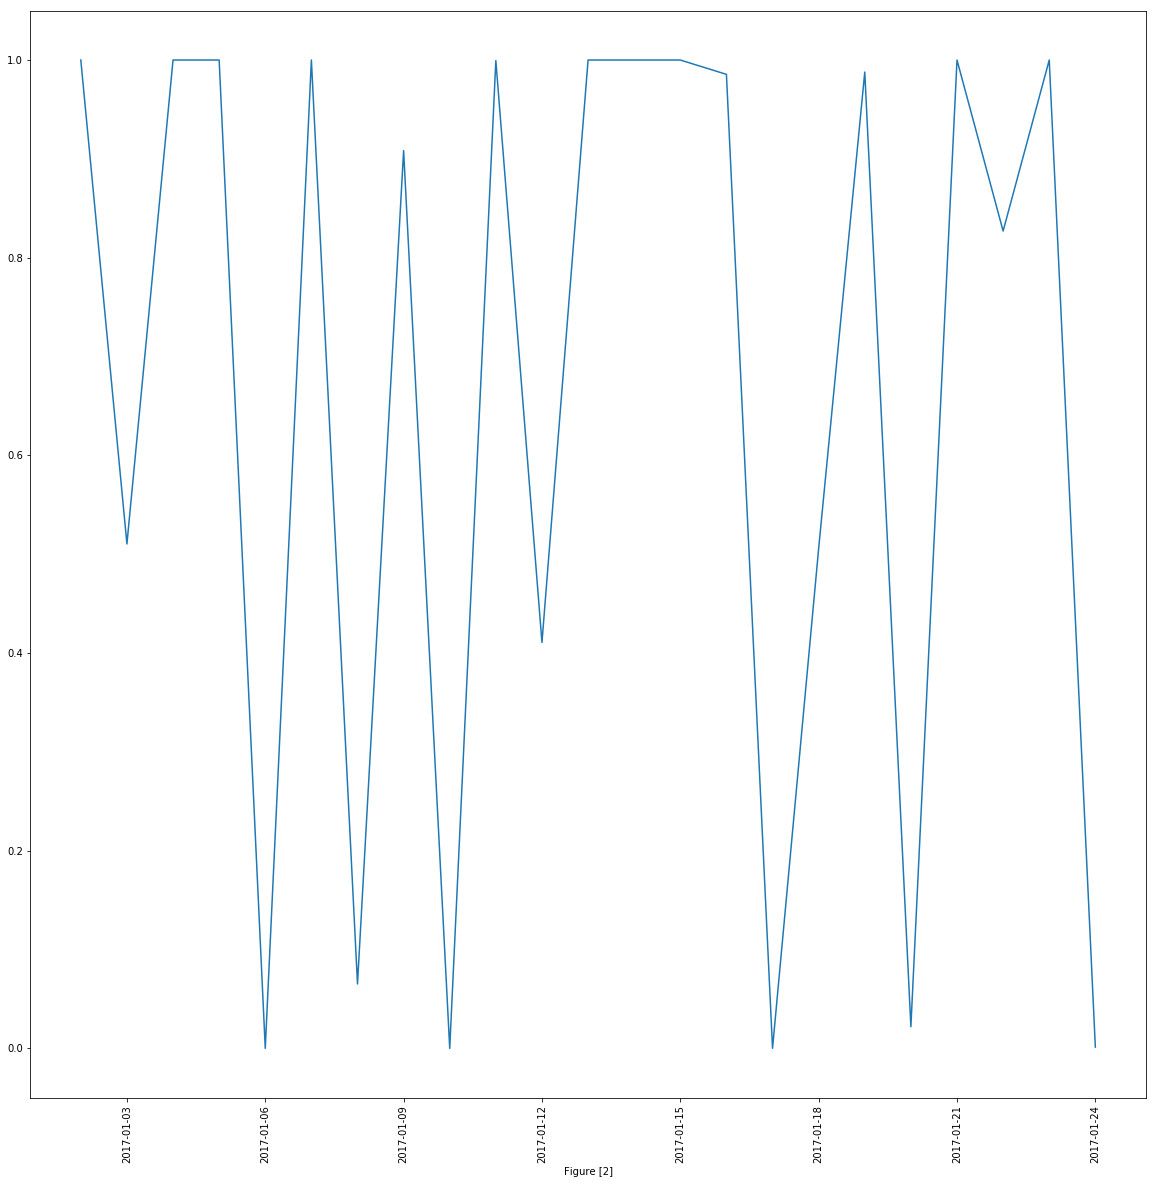

In [178]:
# here we drawing the p-values to see the trend.
fig = plt.figure(figsize=(20,20));
plt.plot(od.keys(), od.values());
plt.xlabel("Figure [2]")
plt.xticks(rotation=90);

#### As we see from Figure[1] and Figure[2] although most of our p-values we get after diving the data are not statstically significant but there are p-values which are statstically significant in specefic days - 4 days- and the p-values are not consistent and there is no trend even in commulative days or day per day shows that the p-values is going down or going up, so I can say that we should give more time for the test and check again to assure if the shapes stay the same as figure[1] and figure[2] this means we can not reject the null and the two pages are approximately equal but if the trend goes up or goes down that means we assure to reject the null if it goes up or reject the null if it goes down and meets the alpha level of siginificant.

<a id='conclusion'></a>
## Final Conclusion

### Part I - Probability:
- the proportion of people who get the new page almost the same as to the people who get the old page.
- the conversion rate is week regardless to the page.
### Part II- A/B Test
- The old page is better than the new page but there is comming suggestion.

### Part III - A regression approach
- The country that the user came from does not influence the conversion rate.
- The page type by each country does not influecne the conversion rate.

### Part IV - Give It More Time Or Not
- I strongly suggest to give the test more time to make sure that by the time there will be no change in favour of new page because there is no trend in shows that it goes down or up and if users are not unique users this may cause change aversion or novelty effect <br>
Novelty effect: https://en.wikipedia.org/wiki/Novelty_effect.<br>
Change Aversion: https://en.wiktionary.org/wiki/change_aversion
- If the company can't give the test more time for some reasons then the resualt is that the old page is better or the same as the new page. 

## Resources:
1- https://sonalake.com/latest/hypothesis-testing-of-proportion-based-samples/ <br>
2- https://www.delftstack.com/howto/python-pandas/how-to-convert-dataframe-column-to-datetime-in-pandas <br>
3- https://stackoverflow.com/questions/9001509/how-can-i-sort-a-dictionary-by-key <br>
4- https://stackoverflow.com/questions/29310116/removing-time-from-datetime-variable-in-pandas <br>
5- https://stackoverflow.com/questions/30487870/python-converting-strings-in-an-array-to-dates <br>
6- https://stackoverflow.com/questions/30340277/how-to-use-variables-inside-query-in-pandas <br>
7- https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib <br>

In [179]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0